In [18]:
%matplotlib notebook
%matplotlib notebook

In [2]:
import sys
sys.path.append('../')
from config import configuration
config = configuration()
config.request_password()

········


In [3]:
import sqlutilpy
data = pd.DataFrame(
         sqlutilpy.get('''select * from thomas_molnar.virac2_variable_data''',
                    **config.wsdb_kwargs)
       )

In [44]:
def get_lightcurve(sourceid):

    lcs = pd.DataFrame(sqlutilpy.get('''select sourceid, 
                                unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as emag,
                                unnest(filterid) as filterid,
                                unnest(chi) as chi,
                                unnest(ast_res_chisq) as ast_res_chisq,
                                unnest(ambiguous_match) as ambiguous_match  
                                from leigh_smith.virac2_ts_tmolnar_variables where sourceid={0}'''.format(sourceid),
                     **config.wsdb_kwargs))
    
    return lcs

def get_lightcurve_bulk(sourceids):

    lcs = pd.DataFrame(sqlutilpy.get('''select sourceid, 
                                unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as emag,
                                unnest(filterid) as filterid,
                                unnest(chi) as chi,
                                unnest(ast_res_chisq) as ast_res_chisq,
                                unnest(ambiguous_match) as ambiguous_match  
                                from leigh_smith.virac2_ts_tmolnar_variables where sourceid in ({0})'''.format((','.join(str(s) for s in sourceids))),
                     **config.wsdb_kwargs))
    
    return [x.reset_index(drop=True) for _, x in lcs.groupby('sourceid')]

In [70]:
fltr = (data['class']=='RRab')&(data['prob']>0.9)#>0.999877)
print(np.count_nonzero(fltr))

sid=data['sourceid'][fltr].values
per=data['lsq_period'][fltr].values

per = per[np.argsort(sid)]
sid = sid[np.argsort(sid)]

52476


<IPython.core.display.Javascript object>


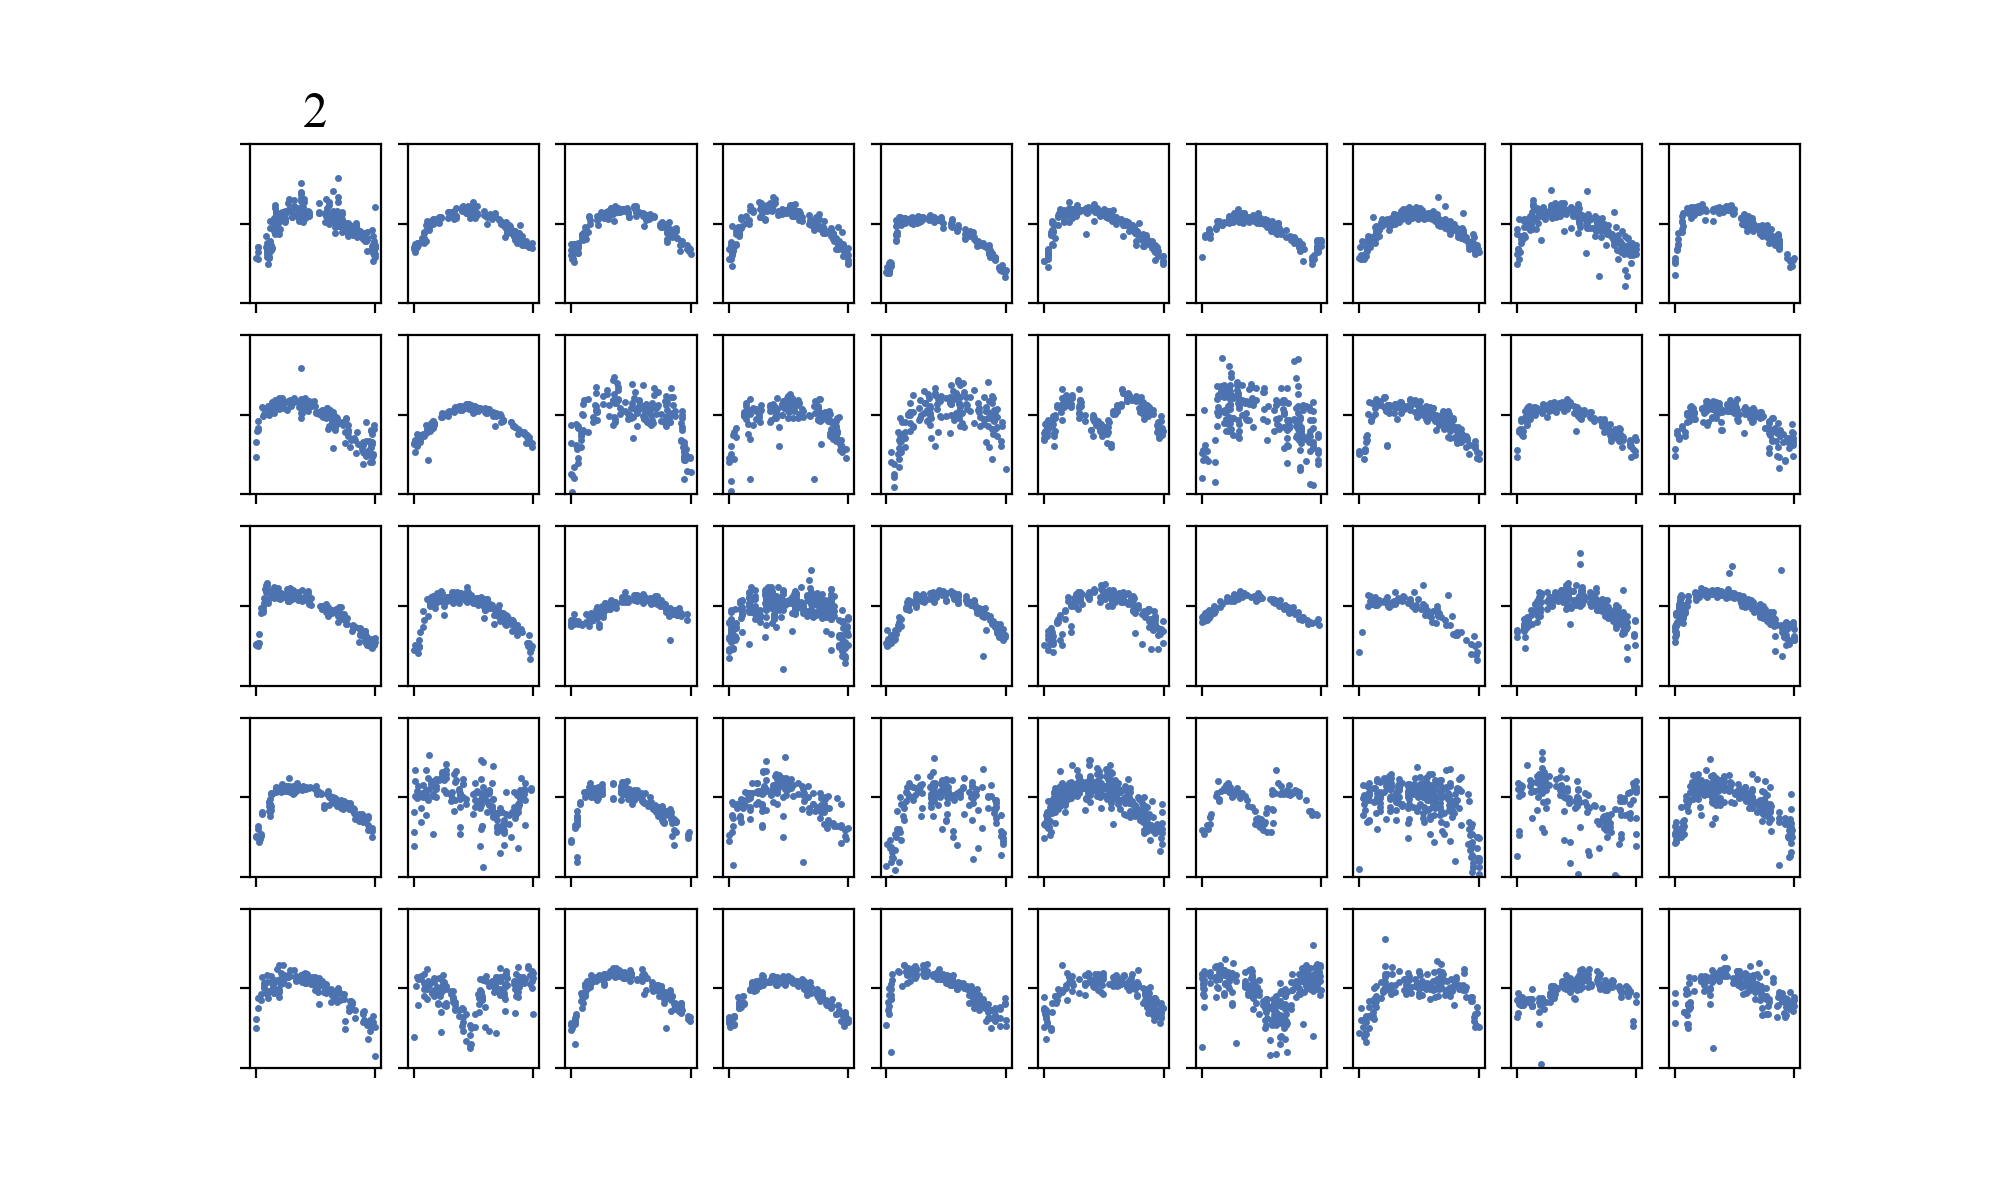

In [73]:
output_file = 'dodgy_rrab.txt'
double_file = 'double_rrab.txt'

NY,NX=5,10
f,a=plt.subplots(NY,NX,figsize=[10,6],sharex=True,sharey=True)
a = a.flatten()

def plllt(lc,period,ax):
    plt.sca(ax)
    plt.cla()
    clean = (lc['filterid']==5)&(lc['ambiguous_match']==0)&(lc['ast_res_chisq']<13.)
    min_t = lc['mjdobs'][clean].values[np.argsort(lc['mag'][clean].values)[-5]]
    plt.plot(((lc['mjdobs'][clean]-min_t)%(period)/period),lc['mag'][clean]-np.nanmedian(lc['mag'][clean]),'.',
            ms=3)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])

event_subplots={}
chunk_index=0

def plot_cl(ain):
    plt.sca(a[ain])
    plt.cla()
    
def plot_grid(chunk):
    
    s = sid[chunk*NY*NX:(chunk+1)*NY*NX]
    p = per[chunk*NY*NX:(chunk+1)*NY*NX]
    lcs = get_lightcurve_bulk(s)
    
    global event_subplots
    event_subplots = {ss:l for l,ss in zip(s,a[:len(s)])}
    
    [plllt(lc,pp,ax) for lc, pp, ax in zip(lcs, p, a)]
    if len(s)<len(a):
        [plot_cl(ain) for ain in range(len(s),len(a))]
        
    plt.ylim(-0.5,0.5)
    plt.sca(a[0])
    plt.title(chunk_index,fontsize=18)
    plt.gca().invert_yaxis()

import os
from functools import partial

def onclick(event):
    with open(output_file, 'a') as w:
        w.write('%i\n' % (event_subplots[event.inaxes]))

def on_press(event):
    sys.stdout.flush()
    global chunk_index
    if event.key == 'n':
        chunk_index+=1
        plot_grid(chunk_index)
        

plot_grid(0)
pid= f.canvas.mpl_connect('key_press_event', on_press)
cid = f.canvas.mpl_connect('button_press_event', onclick)

plt.show()